# IWAE Tutorial

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and Binarising it

In [0]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test =tf.cast(y_test, tf.int64)

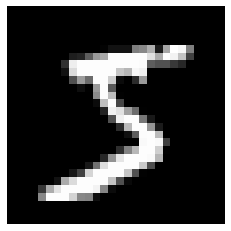

In [4]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

In [0]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

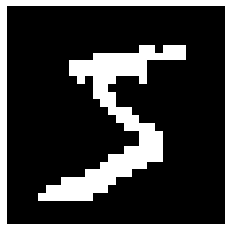

In [6]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

# Theory behind IWAE

The main idea behind IWAE is that we can reformulate the log-likelihood of a Deep Latent Variable Model (DLVM) by using importance Montecarlo sampling. That is, given a PDF $p(x)$, we can approximate the integral $I = \int_\Omega f(x)p(x)dx$ by taking samples of $f(x)$ according to the PDF $p(x)$ so that

$$ I \approx \frac{1}{K} \sum_{k=1}^{K} f(x_k) = \hat{I}_K $$

That is, given the intractable log-likelihood of a DLVM

$$L(\theta) = \sum_{i=1}^N \log p_{\theta}(x_i) \qquad p_{\theta}(x_i) = \int_{\mathbb{R}^d} p_{\theta}(x_i | z)p(z) dz$$

Where $p_{\theta}(x|z) = \Phi(x|f_{\theta} (z))$ is defined by the deep network $f_\theta(z)$, also known as the decoder, can be approximated by sampling from a parametric family of functions 

$$ q_\gamma(z|x) = \Psi (z| g_\gamma(x))$$

Where $g_\gamma(\cdot)$ is known as the encoder of the architecture. The resulting expression for the log-likelihood then becomes

$$\mathcal{L}_K(\theta, \gamma) = \sum_{i=1}^N \mathbb{E}{z_{i1}, \dots, z_{ik} \sim q_\gamma(z|x_i) \Bigg[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_\theta (x_i|z_{ik})p(z_{ik})}{q_\gamma(z_{ik}|x_i)} \Bigg]}$$

Interestingly so, this is a general case of the VAE bound presented by Kingma & Welling (2014), which can be obtained with $\mathcal{L}_1(\theta, \gamma)$, that is:

$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z})p(\mathbf{z})}{q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \right].
$$

This is a lower bound of the likelihood of the deep latent variable model. Rather than the intractable likelihood, we'll  first maximize this bound and further on explore the advantages of using a tighter bound (higher $K$).

To see more clearly the neural nets inside the objective, we may rewrite it as:
$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \left[ \log\frac{\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}))\mathcal{N}(\mathbf{z}|\mathbf{0}_d,\mathbf{I}_d)}{\mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \right].
$$

Even though this might seem like a cumbersome expression, we can simplify the steps required to actually go through it by breaking it down in the following steps:

*   Encode the batch to data points, to get the $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))$ 
*   Use these encoder outputs to define $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$ as a probability distribution
*   Take one sample $\mathbf{z}_i$ from $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$, and use it to:
  *   Compute $\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i))$ by decoding $\mathbf{z}_i$
  *   Compute the rest of the log of $p(\mathbf{z}_i)$ and $q_{\boldsymbol{\gamma}}(\mathbf{z}_i|\mathbf{x}_i)$ 

# Deep latent variable model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net.

In [0]:
# dimension of the latent space
d = 50

# The prior
p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)), reinterpreted_batch_ndims=1)

In [0]:
h = 200 # number of hidden units (same for all dense layers)

act_f = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape = [d,]),
  tfkl.Dense(h, activation = act_f, kernel_initializer = "orthogonal"),
  tfkl.Dense(h, activation = act_f, kernel_initializer = "orthogonal"),
  tfkl.Dense(28 * 28) 
])

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [0]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation = act_f, kernel_initializer = "orthogonal"),
  tfkl.Dense(h, activation = act_f, kernel_initializer = "orthogonal"),
  tfkl.Dense(2 * d) # 2*d because we need both the mean and the diagonal of the covariance
])

## The IWAE objective function

Let's briefly recall the necessary steps to implement the IWAE bound:

*   Encode the batch to data points, to get the $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))$ 
*   Use these encoder outputs to define $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$ as a probability distribution
*   Take one sample $\mathbf{z}_i$ from $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$, and use it to:
  *   Compute $\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i))$ by decoding $\mathbf{z}_i$
  *   Compute the rest of the log of $p(\mathbf{z}_i)$ and $q_{\boldsymbol{\gamma}}(\mathbf{z}_i|\mathbf{x}_i)$ 

In [0]:
@tf.function
def vae_bound(data):

    output_enc = encoder(data)

    mu_encoder = output_enc[..., :d]

    # This function outputs non-negative numbers - it is used to enforce the restriction that the variances must be non-negative
    sigmas_encoder = tf.nn.softplus(output_enc[..., d:])

    q_zgivenx = tfd.Independent(tfd.Normal(loc = mu_encoder, scale = sigmas_encoder), reinterpreted_batch_ndims = 1)

    z_sample = q_zgivenx.sample(1)

    output_dec = decoder(z_sample)

    p_xgivenz = tfd.Independent(tfd.Bernoulli(logits = output_dec), reinterpreted_batch_ndims = 1)

    bound = tf.reduce_mean(p_xgivenz.log_prob(data) + p_z.log_prob(z_sample) - q_zgivenx.log_prob(z_sample))

    return(bound)

In [0]:
# The trainable parameters and optimizer (Adam)
params = list(encoder.trainable_variables) + list(decoder.trainable_variables)  
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [0]:
# Gradient update step
@tf.function
def train_step(data):
    with tf.GradientTape() as tape: 
        bound = vae_bound(data)
        loss = - bound
    gradients = tape.gradient(loss,params) 
    optimizer.apply_gradients(zip(gradients, params))

In [0]:
# Creating the training set
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,y_train)).shuffle(60000).batch(batch_size)

In [151]:
# Training loop
EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    for images, _ in train_dataset:

        train_step(images)

    train_loss[epoch - 1,i] = -vae_bound(images)
    test_loss[epoch - 1,i] = -vae_bound(test_images)
    print("================== EPOCH {} ==================".format(epoch))
    print("Training loss = {0:2.2f}, Testing loss = {1:2.2f}\n".format(train_loss[epoch - 1,i], test_loss[epoch - 1,i]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

================== EPOCH 1 ==================
Training loss = 126.99, Testing loss = 118.54

================== EPOCH 2 ==================
Training loss = 113.05, Testing loss = 105.42

================== EPOCH 3 ==================
Training loss = 93.08, Testing loss = 99.40

================== EPOCH 4 ==================
Training loss = 97.76, Testing loss = 95.86

================== EPOCH 5 ==================
Training loss = 100.49, Testing loss = 94.32

================== EPOCH 6 ==================
Tr

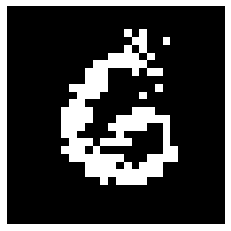

In [153]:
# Let's produce new data - first one image
z_test_sample = p_z.sample(1)

# We run it through the decoder
bernoulli_dist = tfd.Bernoulli(logits = decoder(z_test_sample))

plt.imshow(bernoulli_dist.sample(1).numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

### In-depth training exploration

First let's take a look at how the training and test loss bounds evolve over training, as well a the evolution of the model's generative capabilities by observing some samples change over time

In [ ]:
# Function to play with model parameters
def get_vae_model(d = 50, h = 200, act_f = "relu", initializer = "orthogonal"):

    p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)), reinterpreted_batch_ndims=1)

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape = [d,]),
        tfkl.Dense(h, activation = act_f, kernel_initializer = initializer),
        tfkl.Dense(h, activation = act_f, kernel_initializer = initializer),
        tfkl.Dense(28 * 28) 
    ])

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape = [28 * 28,]),
        tfkl.Dense(h, activation = act_f, kernel_initializer = initializer),
        tfkl.Dense(h, activation = act_f, kernel_initializer = initializer),
        tfkl.Dense(2 * d)
    ])

    params = list(encoder.trainable_variables) + list(decoder.trainable_variables) 
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  
    return encoder, decoder, params, optimizer

In [0]:
# To get the training and testing losses
EPOCHS = 50
n_reps = 10
train_loss = np.zeros((EPOCHS, n_reps))
test_loss = np.zeros((EPOCHS, n_reps))

# To store the samples
n_samples = 20
z_test_sample = p_z.sample(n_samples)
bernoulli_dist = tfd.Bernoulli(logits = decoder(z_test_sample))
img_before = bernoulli_dist.sample(1).numpy()

for i in range(n_reps):
    for epoch in range(1, EPOCHS+1):
        for images, _ in train_dataset:
            train_step(images)
      
        if epoch == int(EPOCHS / 10):
            bernoulli_dist = tfd.Bernoulli(logits = decoder(z_test_sample))
            img_during = bernoulli_dist.sample(1).numpy()
    
        train_loss[epoch - 1,i] = -vae_bound(images)
        test_loss[epoch - 1,i] = -vae_bound(test_images)
        print("================== EPOCH {} ==================".format(epoch))
        print("Training loss = {0:2.2f}, Testing loss = {1:2.2f}\n".format(train_loss[epoch - 1,i], test_loss[epoch - 1,i]))

    encoder, decoder, params, optimizer = get_vae_model()

bernoulli_dist = tfd.Bernoulli(logits = decoder(z_test_sample))
img_after = bernoulli_dist.sample(1).numpy()

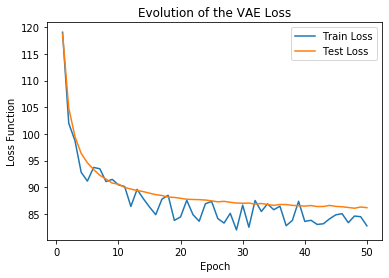

In [48]:
# To plot the evolution of the bounds during training
plt.plot(range(1, EPOCHS + 1), train_loss.mean(1), label = "Train Loss")
plt.plot(range(1, EPOCHS + 1), test_loss.mean(1), label = "Test Loss")
plt.title("Evolution of the VAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Function")
plt.legend()
plt.show()

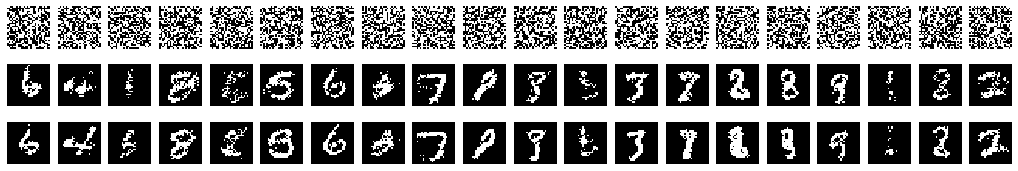

In [18]:
# To visualize the evolution of the generated images
n_samples = img_before.shape[1]
plt.figure(figsize = (18,3))
for i, imgs in enumerate([img_before, img_during, img_after]):
    for j in range(n_samples):
        plt.subplot(3, n_samples, i * n_samples + j + 1)
        plt.imshow(imgs[:,j,:].reshape((28,28)), cmap='gray')
        plt.axis('off')
plt.show()

> In order we observe the 20 samples from before training, after 10% of the epochs have passed and after the training has finished

### Playing with different weight initialization strategies

To verify the important of weight initialization within the scheme of a generative model such as the one presented we can try several approaches and compare their results as follows

In [162]:
init_lst = ["random_normal", "VarianceScaling", "glorot_normal", "glorot_uniform", "he_normal", "lecun_normal"]
EPOCHS = 50
test_loss = np.zeros((EPOCHS, len(init_lst)))

for i, init in enumerate(init_lst):

    encoder, decoder, params, optimizer = get_vae_model(initializer = init)

    for epoch in range(1, EPOCHS + 1):
        for images, _ in train_dataset:
            train_step(images)
    
        test_loss[epoch - 1, i] = -vae_bound(test_images)

    print("\n========= Finished iteration for the {} initializer =========\n".format(init))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Finished iteration for the random_normal initializer

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=F

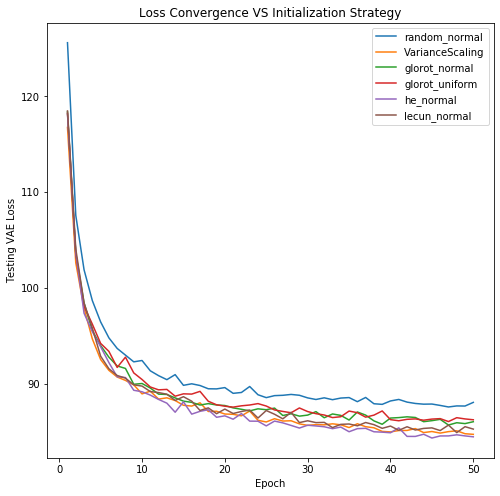

In [164]:
# To plot the results
plt.figure(figsize = (8, 8))
for i, init in enumerate(init_lst):
    plt.plot(range(1, EPOCHS + 1), test_loss[:,i], label = init)
plt.legend()
plt.title("Loss Convergence VS Initialization Strategy")
plt.xlabel("Epoch")
plt.ylabel("Testing VAE Loss")
plt.show()

From the results obtained by training the VAE model with different weight initialization strategies we can corroborate what has been proven experimentally many times: Even though Xavier (glorot) initializers are usually the go-to solution for any NN architecture, it is known that HE initializers work best when we have relu activation layers, which is the case for our VAE architecture, and is corroborated by experimental results. We can also verify that the naïve approach of using random normal initial weights is the slowest converging strategy, and it even doesn't converge towards a "good" local minima of the loss function.

### Representation learning

One of the applications of VAEs is to get a low-dimensional representation of the data. For example, one can replace the high-dimensional data points $\mathbf{x}_i$ by the mean of the corresponding approximate posteriors $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ) \in \mathbb{R}^d$.

Here, we trained a VAE with $d = 50$, which is not readily visualisable. We will now study several ways to visualise the encodings $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i )$ by:

*   Using PCA on the $50$-dimensional embedding $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i )$ to get a bidimensional embedding
*   Training another VAE with $d = 2$, this will be readily visualisable!
*   Using another dimensionality reduction technique such as Multidimensional Scaling (MDS)
* Discussing on which method seems to work best

In [57]:
from sklearn.decomposition import PCA
EPOCHS = 50
pca_original = PCA(n_components = 2).fit(test_images)
orig = pca_original.transform(test_images)

encoder, decoder, params, optimizer = get_vae_model(d = 50, initializer = "he_normal")
for epoch in range(1, EPOCHS + 1):
    for images, _ in train_dataset:
        train_step(images)
pca_50 = PCA(n_components = 2).fit(encoder(test_images).numpy()[:,:50])
pca50 = pca_50.transform(encoder(test_images).numpy()[:,:50])

encoder, decoder, params, optimizer = get_vae_model(d = 2, initializer = "he_normal")
for epoch in range(1, EPOCHS + 1):
    for images, _ in train_dataset:
        train_step(images)
vae_d2 = encoder(test_images).numpy()[:,:2]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



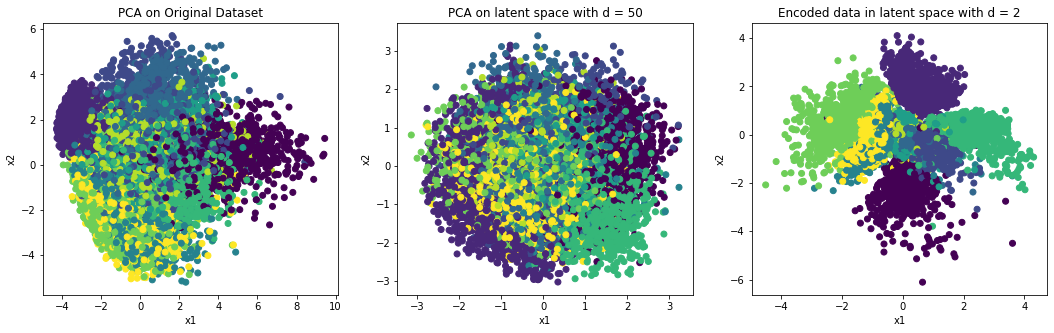

In [58]:
plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
plt.scatter(orig[:,0], orig[:,1], c = y_test)
plt.title("PCA on Original Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.subplot(1,3,2)
plt.scatter(pca50[:,0], pca50[:,1], c = y_test)
plt.title("PCA on latent space with d = 50")
plt.xlabel("x1")
plt.ylabel("x2")
plt.subplot(1,3,3)
plt.scatter(vae_d2[:,0], vae_d2[:,1], c = y_test)
plt.title("Encoded data in latent space with d = 2")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

From the plots obtained above we can see that evidently the representation using a lower latent space (d = 2) is the best one for compressing the information in the dataset. In fact, we can make use of the Calinski-Harabasz metric to measure the ratio of intercluster and intercluster distances for this representation in $\mathcal{R}^2$.

In [59]:
from sklearn.metrics import calinski_harabasz_score
print("PCA on the original dataset = {0:2.2f}".format(calinski_harabasz_score(orig, y_test)))
print("PCA on d = 50 latent space = {0:2.2f}".format(calinski_harabasz_score(pca50, y_test)))
print("The d = 2 latent space = {0:2.2f}".format(calinski_harabasz_score(vae_d2, y_test)))

PCA on the original dataset = 1798.38
PCA on d = 50 latent space = 655.43
The d = 2 latent space = 3392.32


However, while it is intuitive to think that the 2-dimensional latent space would be a good choice for visualizing the mean embeddings it is also important to recall that the objetive of VAE is not to build a lower-dimensional representation of the data, but to find the embeddings which allow for a good estimation of the VAE bound, to which it is important to notice that while the d = 2 representation works well for visualizing the data, it performs much worse when analyzing its testing bound.

A problem of this representation might also be related to the fact that PCA may not be able to reduce the 50-dimension latent space to a 2D one without a considerable loss of information. In fact, if we look at the percentage of variance retained by this representation we notice that only 15% of the variance is explained by the first two principal components of the d = 50 latent space.

We will explore another approach usind Multidimensional Scalind (MDS).

In [64]:
from sklearn.manifold import MDS
idx = np.random.choice(range(test_images.shape[0]), replace = False, size = 500)
mds_original = MDS(n_components = 2, n_jobs = -1).fit_transform(test_images[idx,:])

encoder, decoder, params, optimizer = get_vae_model(d = 50, initializer = "he_normal")
for epoch in range(1, EPOCHS + 1):
    for images, _ in train_dataset:
        train_step(images)
mds_50 = MDS(n_components = 2, n_jobs = -1).fit_transform(encoder(test_images[idx,:]).numpy()[:,:50])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



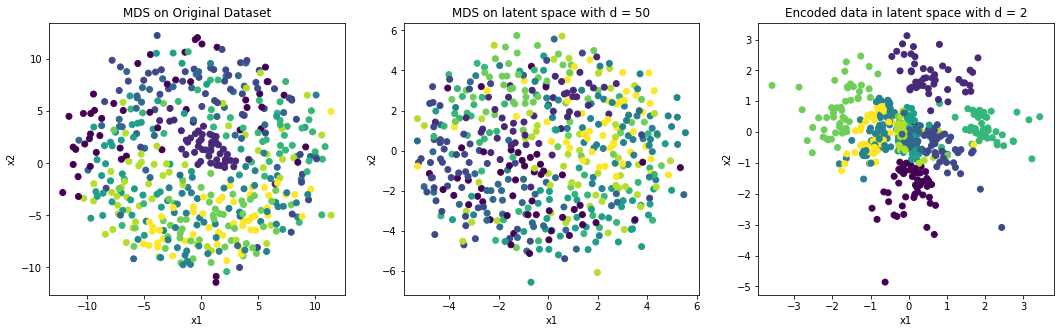

The Calinski-Harabasz Criterion Scores:
MDS on the original dataset = 29.79
MDS on d = 50 latent space = 28.84
The d = 2 latent space = 166.66


In [76]:
plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
plt.scatter(mds_original[:,0], mds_original[:,1], c = y_test.numpy()[idx])
plt.title("MDS on Original Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.subplot(1,3,2)
plt.scatter(mds_50[:,0], mds_50[:,1], c = y_test.numpy()[idx])
plt.title("MDS on latent space with d = 50")
plt.xlabel("x1")
plt.ylabel("x2")
plt.subplot(1,3,3)
plt.scatter(vae_d2[idx,0], vae_d2[idx,1], c = y_test.numpy()[idx])
plt.title("Encoded data in latent space with d = 2")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

print("The Calinski-Harabasz Criterion Scores:")
print("MDS on the original dataset = {0:2.2f}".format(calinski_harabasz_score(mds_original, y_test.numpy()[idx])))
print("MDS on d = 50 latent space = {0:2.2f}".format(calinski_harabasz_score(mds_50, y_test.numpy()[idx])))
print("The d = 2 latent space = {0:2.2f}".format(calinski_harabasz_score(vae_d2[idx,:], y_test.numpy()[idx])))

By looking at the CH scores once more we can observe the same result as before, that the d = 2 embeddings are better for visualizing our dataset even when compared to this new dimensionality reduction technique. 

It is important to note that far fewer points from the testing set were used given that MDS has a time complexity of the order of $\mathcal{O}(n^3)$, which makes using the 10,000 testing samples unfeasable and was opted for only 500 samples.

### Exploring Tighter IWAE Bounds

So far we have restricted our discussion to the classical VAE implementation described by Kingma & Welling (2014), that is the case where $K = 1$. Now we will explore using larger values of $K$, which amounts to using several proposals from the parametric family of gaussians $g_\gamma(\cdot)$. As stated in the paper where IWAE is presented, a higher value of $K$ produces a tighter bound on the posterior's log-likelihood, and should thus, produce better results. 

We will verify this claim by choosing a conservative value of $K = 15$ for training in order to avoid increasing computational demand too much, and a value of $K = 500$ for testing in order to get a good estimate of the testing loss function.

In [ ]:
@tf.function
def train_step(data, k = 1):
    with tf.GradientTape() as tape: 
        bound = vae_bound(data, k)
        loss = - bound
    gradients = tape.gradient(loss, params)  
    optimizer.apply_gradients(zip(gradients, params)) 

@tf.function
def vae_bound(data, k = 1):

    output_enc = encoder(data)
    mu_encoder = output_enc[..., :d]
    sigmas_encoder = tf.nn.softplus(output_enc[..., d:])

    q_zgivenx = tfd.Independent(tfd.Normal(loc = mu_encoder, scale = sigmas_encoder), reinterpreted_batch_ndims = 1)
    z_sample = q_zgivenx.sample(k)

    output_dec = decoder(z_sample)
    p_xgivenz = tfd.Independent(tfd.Bernoulli(logits = output_dec), reinterpreted_batch_ndims = 1)

    bound = tf.reduce_mean(tf.reduce_logsumexp(p_xgivenz.log_prob(data) + p_z.log_prob(z_sample) - q_zgivenx.log_prob(z_sample), axis = 0))

    return(bound)

In [15]:
# To train the general IWAE bound
k_train = 15
k_test = 500
EPOCHS = 50
encoder, decoder, params, optimizer = get_vae_model(d = 50, initializer = "he_normal")
for epoch in range(1, EPOCHS + 1):
    for images, _ in train_dataset:
        train_step(data = images, k = k_train)
    print("Epoch {0:d}: Test Loss = {1:2.2f}".format(epoch, -vae_bound(data = test_images[:1000,:], k = k_test)))
    print("Epoch {0:d}: Train Loss = {1:2.2f}\n".format(epoch, -vae_bound(data = train_images[:1000,:], k = k_test)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1: Test Loss = 95.93
Epoch 1: Train Loss = 93.32

Epoch 2: Test Loss = 85.36
Epoch 2: Train Loss = 83.05

Epoch 3: Test Loss = 80.49
Epoch 3: Train Loss = 77.66

Epoch 4: Test Loss = 77.67
Epoch 4: Train Loss = 74.74

Epoch 5: Test Loss = 75.60
Epoch 5: Train Loss = 72.90

Epoch 6: Test Loss = 74.82
Epoch 6: Train Loss = 71.90

Epoch 7: Test Loss = 73.61
Epoch 7: Train Loss = 71.00

Epoch 8: Test Loss = 72.88
Epoch 8: Train Loss = 69.93

Epoch 9: Test Loss = 71.89
Epoch 9: Train Loss = 69.11

Epoc

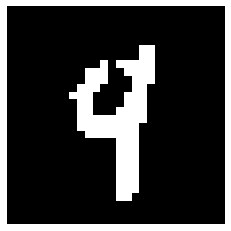

In [24]:
z_test_sample = p_z.sample(1)
bernoulli_dist = tfd.Bernoulli(logits = decoder(z_test_sample))
plt.imshow(bernoulli_dist.sample(1).numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

From the value of the IWAE Loss and the image simulation obtained above we can verify that indeed with a higher number k of MC samples we can obtain a better approximation for the distribution of the data.

### Large-scale IWAE Bound

Finally, in order to evaluate the best hyperparameter configuration for this IWAE implementation we can take a very high IWAE bound for the testing data ($K = 5000$). This metric yields a very good estimate of the true bound and in fact is quite commonly used in the evaluation of DLMVs. This implies that it is a good model evaluation metric to verify the different hyperparameter choices we have made so far.

In [15]:
# To train the several models and test on the large scale IWAE bound
test_idx = np.random.choice(range(test_images.shape[0]), replace = False, size = 20)
EPOCHS = 50

actf_lst = ["relu", "tanh"]
d_lst = [5, 50, 100]
k_lst = [1, 15]
large_iwae_bound = []
model_lst = []
cont = 0

for actf in actf_lst:
    for d_val in d_lst:
        for k_val in k_lst:

            encoder, decoder, params, optimizer = get_vae_model(d = d_val, initializer = "he_normal", act_f = actf)

            for epoch in range(1, EPOCHS + 1):
                for images, _ in train_dataset:
                    train_step(data = images, k = k_val)
                    
            model_lst.append("k = " + str(k_val) + ", d = " + str(d_val) + ", act_f = " + str(actf))
            cont = cont + 1
            print("Finished iteration # {} where {}\n".format(cont, model_lst[cont - 1]))
            large_iwae_bound.append(-vae_bound(data = test_images[test_idx,:], k = 5000))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Finished iteration # 1 where k = 1, d = 5, act_f = relu


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autoca

In [22]:
df = pd.DataFrame({"Model":model_lst, "IWAE Bound":list(map(lambda x: x.numpy(),large_iwae_bound))})
df.sort_values(by = ["IWAE Bound"])

,Model,IWAE Bound
3,"k = 15, d = 50, act_f = relu",58.712749
5,"k = 15, d = 100, act_f = relu",58.725079
4,"k = 1, d = 100, act_f = relu",60.725288
2,"k = 1, d = 50, act_f = relu",61.158470
9,"k = 15, d = 50, act_f = tanh",61.296894
11,"k = 15, d = 100, act_f = tanh",63.343517
8,"k = 1, d = 50, act_f = tanh",66.253082
10,"k = 1, d = 100, act_f = tanh",68.159073
1,"k = 15, d = 5, act_f = relu",81.851479
0,"k = 1, d = 5, act_f = relu",83.337135


From the results obtained we can obtain the following conclusions:

* Very low dimensional latent spaces fail to capture the desired representation and yield very low IWAE bounds (lowest scores)
* Relu activation functions tend to work better than tanh activation functions for these class of VAEs
* As expected by theoretical results, IWAEs ($K>1$) tend to outperfom standard VAEs ($K=1$)
* There is a supremum on the IWAE bound when increasing the latent dimensionality. i.e. from a certain point it is useless to increase the dimensionality further, as no performance is gained after a certain point

Notice however, that these large IWAE testing bounds were computed only on 20 out of the 10,000 testing samples because of GPU memory allocation issues, which would be an important drawback to take into consideration when increasing the bound to such a high value. Given that there are IWAE bounds that have a very small difference, it is important to either repeat this process multiple times, or develop a method which allows to include more samples in the estimation of this metric in order to provide conclusions without uncertainty.